##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons t whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Classifying Images of Clothing

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

Install tensorflow, tensorflow_datasets using pip.

In [1]:
from __future__ import absolute_import, division, print_function


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)

# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


## Import the Fashion MNIST dataset

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [5]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

### Explore the processed data

Let's plot an image to see what it looks like.

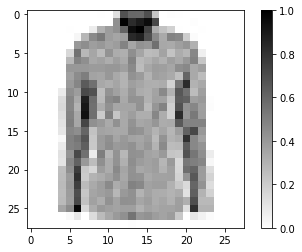

In [6]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

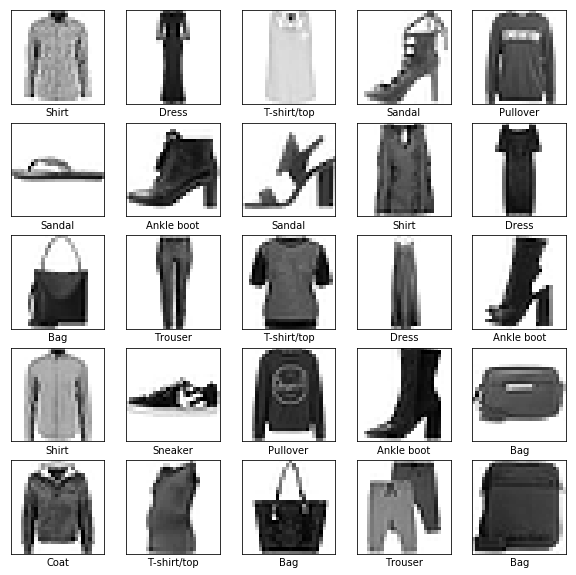

In [7]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

This network has three layers:

* **input** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels), to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it, weights thats input according to learned parameters, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [9]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.



In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 31s 17ms/step - loss: 0.4971 - acc: 0.8235
Epoch 2/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.3758 - acc: 0.8645
Epoch 3/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3331 - acc: 0.8764
Epoch 4/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3154 - acc: 0.8833
Epoch 5/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2917 - acc: 0.8924


## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3660 - acc: 0.8683
Accuracy on test dataset: 0.8683


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [13]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [14]:
predictions.shape


(32, 10)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [15]:
predictions[0]

array([1.7934954e-05, 1.6626325e-06, 4.9940287e-03, 5.5800949e-05,
       3.3180553e-02, 9.7021612e-08, 9.6174246e-01, 3.0168576e-12,
       7.5622729e-06, 5.1187632e-10], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [16]:
np.argmax(predictions[0])

6

So the model is most confident that this image is a shirt, or `class_names[6]`. And we can check the test label to see this is correct:

In [17]:
test_labels[0]

6

We can graph this to look at the full set of 10 channels

In [18]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

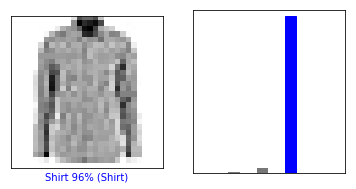

In [19]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

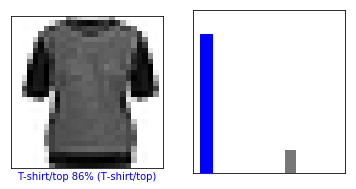

In [20]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

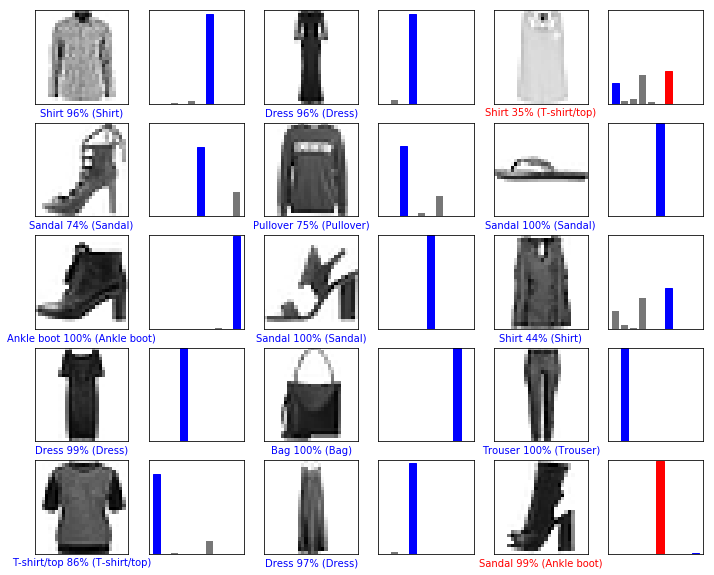

In [21]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image. 

In [22]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [23]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [24]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.7934968e-05 1.6626324e-06 4.9940399e-03 5.5801047e-05 3.3180550e-02
  9.7021783e-08 9.6174234e-01 3.0168628e-12 7.5622861e-06 5.1187526e-10]]


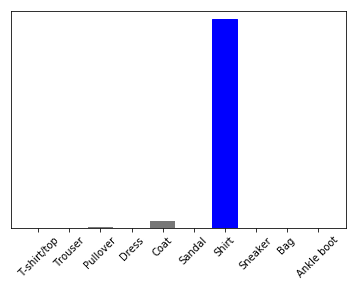

In [25]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [26]:
np.argmax(predictions_single[0])

6

And, as before, the model predicts a label of 6 (shirt).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10,  activation=tf.nn.softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has




In [27]:
#set epoch to 1
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

313/313 [==============================] - 3s 9ms/step - loss: 0.4388 - acc: 0.8395


In [28]:
#Original test data accuracy is 0.8683
#train data with 1 epoch (0.8276) also has lower accuracy than 5 epoch (0.8924)
print('Accuracy on test dataset:', test_accuracy)

Accuracy on test dataset: 0.8395


In [29]:
#testing out acc of different epochs
epochs = []
acc_epoch = []
for i in range(1, 6):
    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_dataset, epochs=i, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
    test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
    epochs.append(i)
    acc_epoch.append(test_accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.4343 - acc: 0.8464
Epoch 1/2
1875/1875 [==============================] - 36s 19ms/step - loss: 0.4930 - acc: 0.8263
Epoch 2/2
313/313 [==============================] - 4s 13ms/step - loss: 0.3860 - acc: 0.8604
Epoch 1/3
1875/1875 [==============================] - 47s 25ms/step - loss: 0.4952 - acc: 0.8241
Epoch 2/3
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3760 - acc: 0.8648
Epoch 3/3
313/313 [==============================] - 3s 10ms/step - loss: 0.4205 - acc: 0.8512
Epoch 1/4
1875/1875 [==============================] - 40s 22ms/step - loss: 0.5035 - acc: 0.8250
Epoch 2/4
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3724 - acc: 0.8662
Epoch 3/4
1875/1875 [==============================] - 27s 15ms/step - loss: 0.3354 - acc: 0.8797
Epoch 4/4
313/313 [==============================] - 3s 10ms/step - loss: 0.3491 - acc: 0.8761
Epoch 1/5
1875/1875 [======================

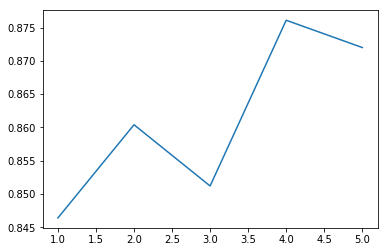

In [30]:
#Graph of different numbers of epoch accuracy comparison
plt.plot(np.arange(1,6), acc_epoch)

In [31]:
#adjusting the number of neurons as suggested, range up to 512
epoch = 1
neurons = []
accs = []
for i in range(10, 513, 100):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(i, activation=tf.nn.relu),
        tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(train_dataset, epochs=epoch, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
    test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
    neurons.append(i)
    accs.append(test_accuracy)

313/313 [==============================] - 4s 11ms/step - loss: 0.4047 - acc: 0.8560


[10, 110, 210, 310, 410, 510]


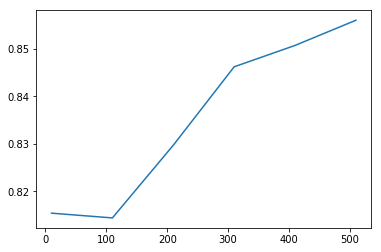

In [33]:
#Affects of number of neurons on acc, neurons increment by 100
plt.plot(neurons, accs)
print(neurons)

In [34]:
#Additional layer for model, Dense(10, activation=tf.nn.relu)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

Epoch 1/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.5613 - acc: 0.8003
Epoch 2/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3842 - acc: 0.8630
Epoch 3/5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.3506 - acc: 0.8747
Epoch 4/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3250 - acc: 0.8810
Epoch 5/5
313/313 [==============================] - 3s 11ms/step - loss: 0.3444 - acc: 0.8746


In [35]:
print('Accuracy on test dataset:', test_accuracy)

Accuracy on test dataset: 0.8746


In [36]:
#Denormalizing train and test dataset
train_dataset_not_normalize, test_dataset_not_normalize = dataset['train'], dataset['test']
train_dataset_not_normalize = train_dataset_not_normalize.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset_not_normalize = test_dataset_not_normalize.batch(BATCH_SIZE)

In [37]:
#Effects of denormalization
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset_not_normalize, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
test_loss, test_accuracy = model.evaluate(test_dataset_not_normalize, steps=math.ceil(num_test_examples/32))

Epoch 1/5
1875/1875 [==============================] - 35s 19ms/step - loss: 13.5641 - acc: 0.1583
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 14.4767 - acc: 0.1018
Epoch 3/5
1875/1875 [==============================] - 27s 14ms/step - loss: 14.5017 - acc: 0.1003
Epoch 4/5
1875/1875 [==============================] - 24s 13ms/step - loss: 14.4888 - acc: 0.1011
Epoch 5/5
313/313 [==============================] - 3s 11ms/step - loss: 14.5056 - acc: 0.1000


In [38]:
#accuracy becomes low
print('Accuracy on test dataset:', test_accuracy)

Accuracy on test dataset: 0.1
